## Exploratory Data Analysis

Now that we have over a million data points, let's take some time to find patterns in the stock market. Surely there are some repeatable trends over the last 15 years, right?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
stocks = pd.read_hdf('../data/raw/market_stocks.h5', key='top_stocks')

# Double checking that the data is sorted by date.
stocks = stocks.sort_index()

symbols = stocks.symbol.unique()

Before I can get started, I need to calculate two important features. First I'll group the data by symbol, to avoid overlap.

In [3]:
stocks_by_symbol = stocks.groupby('symbol')

groups = np.empty(len(symbols), dtype=object)

for i, symbol in tqdm(enumerate(symbols)):
    groups[i] = stocks_by_symbol.get_group(symbol)

The forecast represents the ratio between the close price of the following day and the close price of the current day. If the forecast is positive, then the buy signal is 1, otherwise 0. These two features are used as target variables to predict future prices. They can also be used to answer some questions about stock market trends, which is why I calculate them here.

In [4]:
stocks = np.empty(len(groups), dtype=object)

for i, group in tqdm(enumerate(groups)):
    stock = group.copy()
    
    # Forecast
    stock['forecast'] = -stock.close.diff(-1) / stock.close

    # Buy Signal
    stock['buy_signal'] = (stock.loc[:, 'forecast'] > 0).astype(float)
    
    stocks[i] = stock

The stocks are concatenated back together.

In [5]:
stocks = pd.concat(stocks).replace([np.inf, -np.inf], np.nan).dropna()

First, a look at the market as a whole. Using the SPY ETF gives a good estimate for this. You can make out the market crash of 2008 and the recovery. The last few months have been volatile, but overall the market has a steady upward momentum. It's clear that long term investments have been profitable.

In [6]:
spy = stocks[stocks.symbol == 'SPY'].copy()

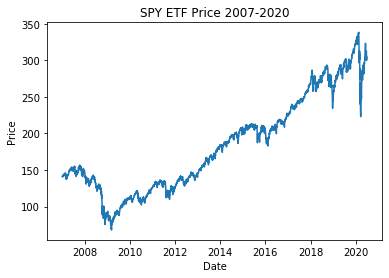

In [7]:
_ = plt.plot(spy.close)
_ = plt.xlabel('Date')
_ = plt.ylabel('Price')
_ = plt.title('SPY ETF Price 2007-2020')

To get a closer look, I've separated the three years I will be using to test my models.

In [8]:
spy_2008 = spy['2008'].copy()
spy_2011 = spy['2011'].copy()
spy_2013 = spy['2013'].copy()

By shifting each year's starting point to 0, you can see how they compare. 2008's drop didn't reach its peak until the latter half of the year. 2011's price ended up nearly at the same point it started at. 2013 showed a consistent growth in its market price.

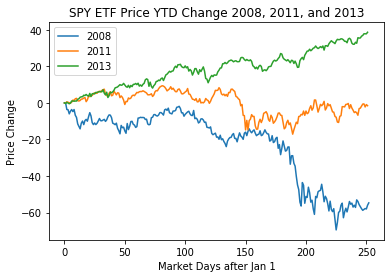

In [9]:
plt.plot(range(253), spy_2008.close - spy_2008.close[0], label='2008')
plt.plot(range(252), spy_2011.close - spy_2011.close[0], label='2011')
plt.plot(range(252), spy_2013.close - spy_2013.close[0], label='2013')

plt.legend()

_ = plt.xlabel('Market Days after Jan 1')
_ = plt.ylabel('Price Change')
_ = plt.title('SPY ETF Price YTD Change 2008, 2011, and 2013')

How dot the forecasts in each year compare? In 2008, the mean forecast was negative. The other two years have positive forecasts, as expected.

In [10]:
spy_2008.forecast.mean(), spy_2011.forecast.mean(), spy_2013.forecast.mean()

(-0.0014174057505079714, 0.00011928134752258592, 0.0009169177694427585)

Surprisingly, the median shows a positive forecast for 2008. There were actually more positive days than negative ones, even during a recession. However, the price change on negative days outweighed the price change on positive days. The median forecasts for 2011 and 2013 are both positive and greater than 2008.

In [11]:
spy_2008.forecast.median(), spy_2011.forecast.median(), spy_2013.forecast.median()

(0.00014238929232508762, 0.0007721933606036401, 0.0011662492135086516)

Are there any weekly patterns for stock market movement? Mondays have the best average return of all the weekdays. Thursdays and Fridays actually average a negative forecast. Wednesdays have the highest median forecast. Every day of the week has had more positive days than negative days. According to these results, you should buy stocks on Mondays and sell them on Thursdays. More testing would be needed to see if this trend holds true for other time periods.

In [12]:
for d, name in zip(range(5), ['Monday:    ', 'Tuesday:   ', 'Wednesday: ', 'Thursday: ', 'Friday:   ']):
    print(name,
          round(spy[spy.index.dayofweek == d].forecast.mean(), ndigits=5),
          round(spy[spy.index.dayofweek == d].forecast.median(), ndigits=5))

Monday:     0.00134 0.00068
Tuesday:    0.00039 0.0006
Wednesday:  0.0003 0.00108
Thursday:  -0.00032 0.00042
Friday:    -6e-05 0.00034


A boxplot shows that the differences between days are minimal.

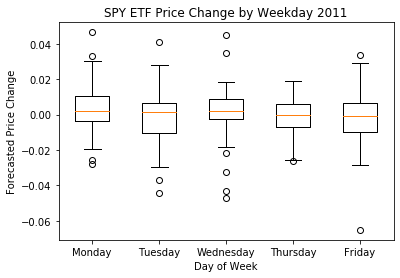

In [13]:
_ = plt.boxplot([spy_2011[spy_2011.index.dayofweek == d].forecast
                for d in range(5)])

_ = plt.xlabel('Day of Week')
_ = plt.ylabel('Forecasted Price Change')
_ = plt.title('SPY ETF Price Change by Weekday 2011')
_ = plt.xticks([1, 2, 3, 4, 5], ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])

How often does a positive day result in another positive day? You can find out by looking at a rolling window of two days, and summing the buy signals. A result of 2 represents two positive days. A result of 0 represents two negative days.

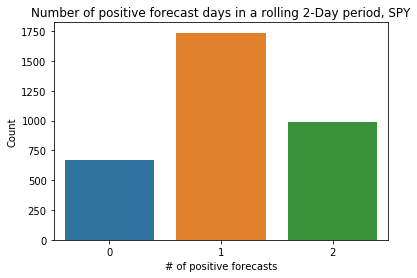

In [14]:
sns.countplot(spy.buy_signal.rolling(2).sum().dropna().astype(int))

_ = plt.xlabel('# of positive forecasts')
_ = plt.ylabel('Count')
_ = plt.title('Number of positive forecast days in a rolling 2-Day period, SPY')

While positive trends are more common than negative trends, days where the signal reversed were more common than days where the signal continued.

In [15]:
spy.buy_signal.rolling(2).sum().value_counts()

1.0    1736
2.0     986
0.0     673
Name: buy_signal, dtype: int64

By instead taking the difference between the buy signals, you can determine the direction of the trend reversal. A 1 represents a positive day followed by a negative day, and a -1 represents a negative day followed by a positive day. Both catagories contain exactly the same number of observations.

In [16]:
spy.buy_signal.rolling(2).apply(lambda x: x[0] - x[1], raw=True).value_counts()

 0.0    1659
-1.0     868
 1.0     868
Name: buy_signal, dtype: int64

By increasing the rolling window size, you can get a picture of the frequency of longer trends. The distribution appears normal, with a peak at 11 positive days. It is very rare for there to be extended periods of positive or negative days. However, the market has had a positive bias on the whole.

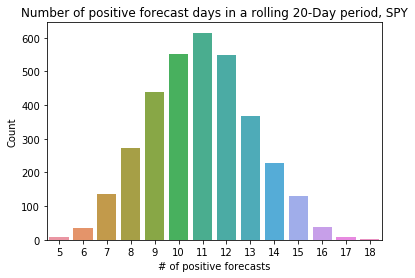

In [17]:
sns.countplot(spy.buy_signal.rolling(20).sum().dropna().astype(int))

_ = plt.xlabel('# of positive forecasts')
_ = plt.ylabel('Count')
_ = plt.title('Number of positive forecast days in a rolling 20-Day period, SPY')

Do those 11 positive days represent a positive increase in the close price? After all, the negative days may outweigh the positive. By looking at the forecast instead of the signal, the average gain in a 20 day period is 0.6%. The market indeed appears to go up over time.

In [18]:
spy.forecast.rolling(20).sum().mean()

0.006338189355841875

The peak in the graph appears to be at zero. However, the right tail has more area than the left tail, showing a positive forecast trend.

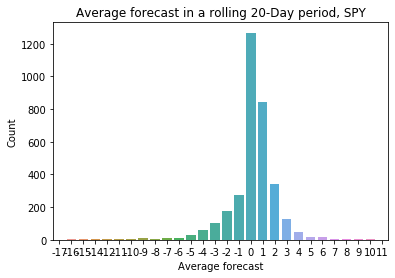

In [19]:
sns.countplot((spy.forecast.rolling(20).sum().dropna() * 50).astype(int))

_ = plt.xlabel('Average forecast')
_ = plt.ylabel('Count')
_ = plt.title('Average forecast in a rolling 20-Day period, SPY')

How much of an influence does the market have on individual stocks? To test this, I will pull out two well known companies, Apple and Microsoft.

In [20]:
apple = stocks[stocks.symbol == 'AAPL'].copy()

apple['forecast'] = -apple.close.diff(-1) / apple.close
apple['buy_signal'] = (apple.loc[:, 'forecast'] > 0).astype(float)

apple.dropna(inplace=True)

In [21]:
microsoft = stocks[stocks.symbol == 'MSFT'].copy()

microsoft['forecast'] = -microsoft.close.diff(-1) / microsoft.close
microsoft['buy_signal'] = (microsoft.loc[:, 'forecast'] > 0).astype(float)

microsoft.dropna(inplace=True)

Looking at the entire timeline, both Microsoft and Apple have similar stock price trajectories to the market as a whole.

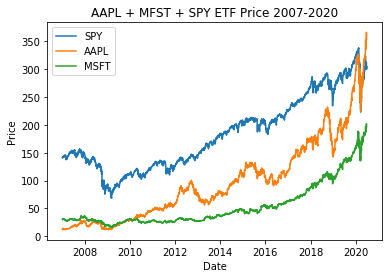

In [22]:
_ = plt.plot(spy.close, label='SPY')
_ = plt.plot(apple.close, label='AAPL')
_ = plt.plot(microsoft.close, label='MSFT')
_ = plt.xlabel('Date')
_ = plt.ylabel('Price')

_ = plt.legend()
_ = plt.title('AAPL + MFST + SPY ETF Price 2007-2020')

Microsoft has very similar results when looking at the three backtesting years.

In [23]:
microsoft_2008 = microsoft['2008'].copy()
microsoft_2011 = microsoft['2011'].copy()
microsoft_2013 = microsoft['2013'].copy()

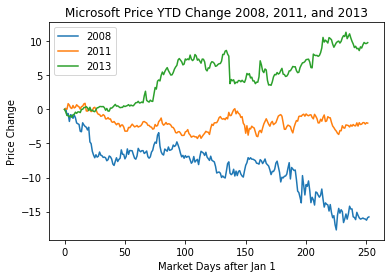

In [24]:
plt.plot(range(253), microsoft_2008.close - microsoft_2008.close[0], label='2008')
plt.plot(range(252), microsoft_2011.close - microsoft_2011.close[0], label='2011')
plt.plot(range(252), microsoft_2013.close - microsoft_2013.close[0], label='2013')

plt.legend()

_ = plt.xlabel('Market Days after Jan 1')
_ = plt.ylabel('Price Change')
_ = plt.title('Microsoft Price YTD Change 2008, 2011, and 2013')

Apple, however, had a very disappointing 2013 and did not share the growth experienced by overall market. Research reveals that Apple was struggling with falling iPhone sales and a lower profit margin at the beginning of 2013, which contributed to its price drop. It is clear that the market has a strong influence on stock prices, but individual events can overcome this influence.

In [25]:
apple_2008 = apple['2008'].copy()
apple_2011 = apple['2011'].copy()
apple_2013 = apple['2013'].copy()

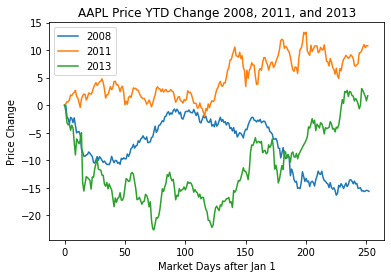

In [26]:
plt.plot(range(253), apple_2008.close - apple_2008.close[0], label='2008')
plt.plot(range(252), apple_2011.close - apple_2011.close[0], label='2011')
plt.plot(range(252), apple_2013.close - apple_2013.close[0], label='2013')

plt.legend()

_ = plt.xlabel('Market Days after Jan 1')
_ = plt.ylabel('Price Change')
_ = plt.title('AAPL Price YTD Change 2008, 2011, and 2013')

Looking at the numbers, Apple's buy signal matched SPY's buy signal 69% of the time.

In [27]:
(spy.buy_signal[:-1] == apple.buy_signal).value_counts()

True     2347
False    1048
Name: buy_signal, dtype: int64

Microsoft's buy signal matched the merket's buy signal 74% of the time.

In [28]:
(spy.buy_signal[:-1] == microsoft.buy_signal).value_counts()

True     2508
False     887
Name: buy_signal, dtype: int64

To look at all stocks, I made a column called 'market trend' that is True when the buy signal matches the market's buy signal, and False otherwise.

In [29]:
stocks = stocks.join(spy.buy_signal, rsuffix='_market')

In [30]:
stocks['market_trend'] = stocks.buy_signal == stocks.buy_signal_market

Overall, the market forecast matches individual stock forecasts ~63% of the time. 

In [31]:
stocks.market_trend.value_counts()

True     1094467
False     456176
Name: market_trend, dtype: int64

In [32]:
stocks.groupby('date').market_trend.sum().mean() / len(symbols)

0.6369193936600603

I looked into the top ten stocks by market influence. Five of the top ten stocks are financial institutions. It makes sense for financial stocks to match the market, as their operations rely on a strong market.

In [33]:
(stocks.groupby('symbol').market_trend.sum() / stocks.groupby('symbol').market_trend.count()).nlargest(11)

symbol
SPY     1.000000
AMP     0.784747
TROW    0.782686
PFG     0.782391
L       0.775281
HON     0.774735
ETN     0.772968
ITW     0.770907
BEN     0.770612
PRU     0.770612
PPG     0.768551
Name: market_trend, dtype: float64

The bottom ten stocks contain a variety of institutions. Notably, a gold mining corporation ranks low on the list. Gold tends to do better when the market crashes, which might explain the disparity. RTX is the only stock with a trend below 50%, might be an outlier. There are only 300 datapoints for RTX when compared to the 3,000 of most stocks, so more data may be needed.

In [34]:
(stocks.groupby('symbol').market_trend.sum() / stocks.groupby('symbol').market_trend.count()).nsmallest(10)

symbol
RTX     0.368263
PEAK    0.582677
NEM     0.585100
WELL    0.586735
EVRG    0.587332
VIAC    0.604972
COTY    0.607103
CARR    0.616667
TWTR    0.619128
AWK     0.622881
Name: market_trend, dtype: float64